In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pychattr
import itertools
from collections import defaultdict
from math import factorial
import numpy as np
import glob

from pychattr.channel_attribution import PyChAttr
# from pychattr.ChannelAttribution import PyChAttr 

# What is this channel_attribution library JASON!? https://github.com/jmwoloso/pychattr

sns.set_style("darkgrid")

In [2]:
os.getcwd()

'/home/jason/code/python/multi_touch_attribution/dev/notebooks'

# Attribution

In [2]:
# # generator function
# def files(path=None):
#     """Generator function for gathering files in a directory."""
#     # only reversing since utm_source is the primary
#     # concern relative to the other features we're 
#     # modeling
#     for file in os.listdir(path)[::-1]:
#         if os.path.isfile(os.path.join(path, file)):
#             yield file

In [3]:
# folder containing the processed feature data
BASEDIR="../"
FILEDIR="data/"
OUTPUTDIR="data/model_output/"

# raw data
# FT_RAW_DATA="free_trial_and_demo_path_data_raw.csv.gz"
# FT_RAW_DATA=""
RAW_DCM_DATA="dcm_free_trial_and_demo_path_data_raw.csv.gz"

# final data 
FT_DATA="bn_free_trial_path_data_final.csv.gz"
PD_DATA="paid_path_data_final.csv.gz"

DCM_FT_DATA="dcm_free_trial_and_demo_path_data_final.csv.gz"
HDYHAU_DATA="sa_hdyhau_data_final.csv.gz"


In [11]:
# Preprocessing raw data 
def concat_paths(x):
    """Concats the paths for each user"""
    # return " > ".join(x)
    return ",".join(x)

# # didn't work
# df = pd.read_gbq(
#     sql,
#     project_id='infusionsoft-looker-poc',
#     dialect='standard'
# )

df = pd.read_csv(BASEDIR + FILEDIR + FT_RAW_DATA, 
    header=0,
    compression="gzip",
    low_memory=False
)

# filter out records with more than 90 (3 per day) visits over the
# last month (of good data)
filtered_gb = df.groupby(
    ["heap_user_id"],
    as_index=False
)\
    .agg(
    {
        "channel": "count"
    }
)\
    .sort_values(
    by="channel",
    ascending=False
)

bot_mask = filtered_gb.loc[:, "channel"] > 90
bot_ids = filtered_gb.loc[bot_mask, "heap_user_id"].values

# remove the bots
non_bot_mask = ~df.loc[:, "heap_user_id"].isin(bot_ids)
df = df.loc[non_bot_mask, :].copy()


# FILEPATH="free_trial/data/test.csv"
# read in the data
ft_df = df.loc[:, ["heap_user_id", "channel",
                   "free_trial_converted", "mrr"]].copy()

pd_df = df.loc[:, ["heap_user_id", "channel",
                   "paid_converted", "mrr"]].copy()


# groupby heap user id and concat the events per to create the paths
ft_gb = ft_df.groupby(
    ["heap_user_id",
     "free_trial_converted"],
    as_index=False)\
    .agg(
    {
        "channel": concat_paths,
        "mrr": "sum"
    }
)

pd_gb = pd_df.groupby(
    ["heap_user_id",
     "paid_converted"],
    as_index=False) \
    .agg(
    {
        "channel": concat_paths,
        "mrr": "sum"
    }
)

# separate the conversions from the nulls
ft_zeros_mask = ft_gb.loc[:, "free_trial_converted"] == 0
ft_ones_mask = ft_gb.loc[:, "free_trial_converted"] == 1
pd_zeros_mask = pd_gb.loc[:, "paid_converted"] == 0
pd_ones_mask = pd_gb.loc[:, "paid_converted"] == 1

ft_zeros_df = ft_gb.loc[ft_zeros_mask, :].copy()
ft_ones_df = ft_gb.loc[ft_ones_mask, :].copy()
pd_zeros_df = pd_gb.loc[pd_zeros_mask, :].copy()
pd_ones_df = pd_gb.loc[pd_ones_mask, :].copy()

# groupby activity name and add up the counts for each; these
# represent the nulls (no conversion resulting from these paths)
ft_zeros_gb = ft_zeros_df.groupby(
    "channel",
    as_index=False)\
    .agg(
    {
        "free_trial_converted": "count",
        "mrr": "sum"
    }
)\
    .rename(
    columns={
        "free_trial_converted": "total_null",
        "mrr": "total_conversion_value",
        "channel": "path"
    }

)

# groupby activity name and add up the counts for each; these
# represent the conversions resulting from each path
ft_ones_gb = ft_ones_df.groupby(
    "channel",
    as_index=False)\
    .agg(
    {
        "free_trial_converted": "count",
        "mrr": "sum"

    }
)\
    .rename(
    columns={
        "free_trial_converted": "total_conversions",
        "mrr": "total_conversion_value",
        "channel": "path"
    }
)



pd_zeros_gb = pd_zeros_df.groupby(
    "channel",
    as_index=False) \
    .agg(
    {
        "paid_converted": "count",
        "mrr": "sum"
    }
) \
    .rename(
    columns={
        "paid_converted": "total_null",
        "mrr": "total_conversion_value",
        "channel": "path"
    }

)

# groupby activity name and add up the counts for each; these
# represent the conversions resulting from each path
pd_ones_gb = pd_ones_df.groupby(
    "channel",
    as_index=False) \
    .agg(
    {
        "paid_converted": "count",
        "mrr": "sum"

    }
) \
    .rename(
    columns={
        "paid_converted": "total_conversions",
        "mrr": "total_conversion_value",
        "channel": "path"
    }
)




# merge the nulls and conversions together by path
ft_path_df = pd.merge(ft_zeros_gb,
                      ft_ones_gb,
                      how="outer",
                      on=["path",
                          "total_conversion_value"])
ft_path_df = ft_path_df.fillna(value=0)
ft_path_df.to_csv(BASEDIR + FILEDIR + FT_DATA,
                  header=True,
                  index=False,
                  compression="gzip")



# Create the Free-Trial Model

/Users/sana.asghar/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


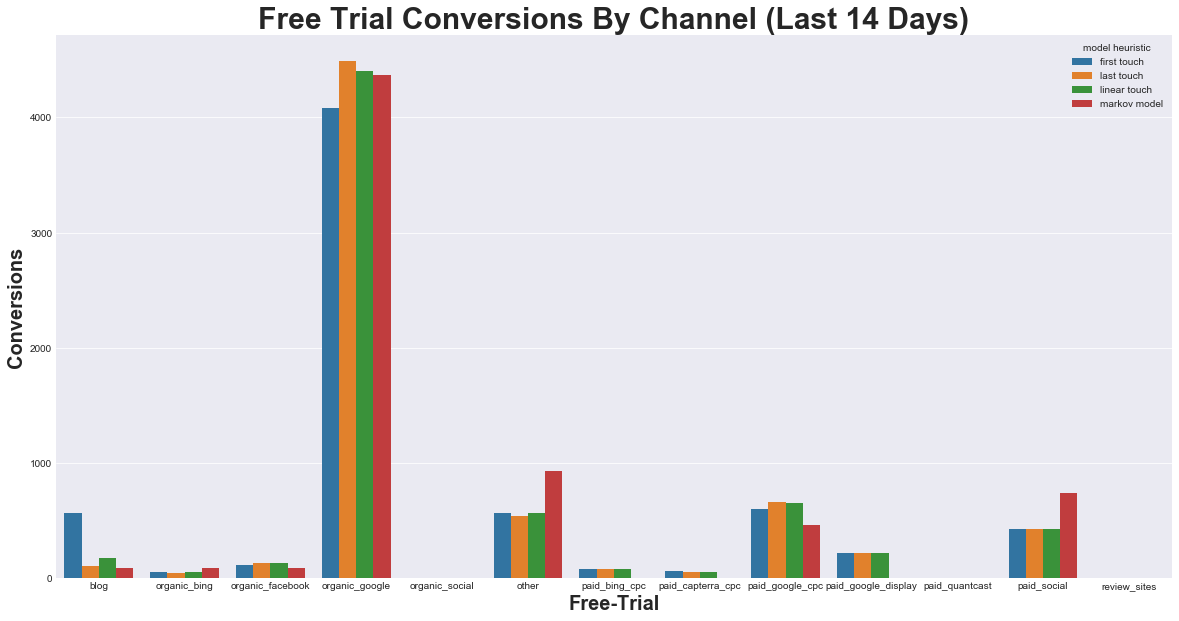

In [16]:
path_df = pd.read_csv(BASEDIR + FILEDIR + DCM_FT_DATA,
                      header=0,
                      compression="gzip")
# specs for the model
path_model = PyChAttr(df=path_df,
                      markov_model=True,
                      heuristic_model=True,
                      first_touch=True,
                      last_touch=True,
                      linear_touch=True,
                      path_feature="path",
                      conversion_feature="total_conversions",
                      conversion_value_feature=None,
                      null_path_feature="total_null",
                      separator=">",
                      order=42, # based on the longest path in the dataset
                      n_simulations=10000,
                      max_step=1, # determined based on the median number of visits 
                      return_transition_probs=True,
                      random_state=26,
                      return_plot_data=True)

# fit the model
path_model.fit()


# many of the attributes are just dataframes with the model results
model = path_model.model_
model.to_csv(BASEDIR + OUTPUTDIR + "dcm_free_trial_model_1.csv",
             header=True,
             index=False)

# transition matrix
transition_matrix = path_model.transition_matrix_
transition_matrix.to_csv(BASEDIR + OUTPUTDIR + "dcm_free_trial_transition_matrix.csv",
                         header=True,
                         index=False)

# removal effects
removal_effects = path_model.removal_effects_
removal_effects.to_csv(BASEDIR + OUTPUTDIR + "dcm_free_trial_removal_effects.csv",
                       header=True,
                       index=False)

# markov and heuristic models
markov = path_model.markov_
heuristic = path_model.heuristic_

conversion_features = path_model.conversion_features_
# conversion_value_features = path_model.conversion_value_features_
conv_df = path_model.melted_data_[0]
# conv_val_df = path_model.melted_data_[1]


# make the plots
plt.figure(figsize=(20, 10))

# plot the bars
sns.barplot(x="channel name",
            y="total conversions",
            hue="model heuristic",
            data=conv_df)

# source_title = file[:-13].replace("_", " ").title()
plt.xlabel("Free-Trial",
           size=20,
           weight="bold")

plt.ylabel("Conversions",
           size=20,
           weight="bold")

plt.title("Free Trial Conversions By Channel (Last 14 Days)",
          size=30,
          weight="bold")

plt.show()

In [10]:
# Create the Paid Model
conv_df

,channel name,model heuristic,total conversions
0,blog,first touch,564.000000
1,other,first touch,571.000000
2,organic_google,first touch,4079.000000
3,organic_facebook,first touch,113.000000
4,paid_social,first touch,428.000000
5,organic_bing,first touch,53.000000
6,paid_google_display,first touch,222.000000
7,paid_google_cpc,first touch,601.000000
8,paid_bing_cpc,first touch,82.000000
9,review_sites,first touch,1.000000


In [ ]:
pd_path_df = pd.read_csv(BASEDIR + FILEDIR + PD_DATA,
                      header=0,
                      compression="gzip")
# specs for the model
path_model = PyChAttr(df=pd_path_df,
                      markov_model=True,
                      heuristic_model=True,
                      first_touch=True,
                      last_touch=True,
                      linear_touch=True,
                      path_feature="path",
                      conversion_feature="total_conversions",
#                       conversion_value_feature="total_conversion_value",
                      null_path_feature="total_null",
                      separator=">",
                      order=42, # based on the longest path in the dataset
                      n_simulations=10000000,
                      max_step=1, # determined based on the median number of visits 
                      return_transition_probs=True,
                      random_state=26,
                      return_plot_data=True)

# fit the model
path_model.fit()


# many of the attributes are just dataframes with the model results
model = path_model.model_
model.to_csv(BASEDIR + OUTPUTDIR + "paid_model.csv",
             header=True,
             index=False)

# transition matrix
transition_matrix = path_model.transition_matrix_
transition_matrix.to_csv(BASEDIR + OUTPUTDIR + "paid_transition_matrix.csv",
                         header=True,
                         index=False)

# removal effects
removal_effects = path_model.removal_effects_
removal_effects.to_csv(BASEDIR + OUTPUTDIR + "paid_removal_effects.csv",
                       header=True,
                       index=False)

# markov and heuristic models
markov = path_model.markov_
heuristic = path_model.heuristic_

conversion_features = path_model.conversion_features_
# conversion_value_features = path_model.conversion_value_features_
conv_df = path_model.melted_data_[0]
# conv_val_df = path_model.melted_data_[1]


# make the plots
plt.figure(figsize=(20, 10))

# plot the bars
sns.barplot(x="channel name",
            y="total conversions",
            hue="model heuristic",
            data=conv_df)

# source_title = file[:-13].replace("_", " ").title()
plt.xlabel("Paid",
           size=20,
           weight="bold")

plt.ylabel("Conversions",
           size=20,
           weight="bold")

plt.title("Total Conversions By Channel - Paid",
    # Create the Free-Trial Model      size=30,
          weight="bold")

plt.show()

# Shapley Implementation 

In [ ]:
# Shapley without HDYHAU Data to assess Organic / Paid weights

In [ ]:
shap_path_df = pd.read_csv(BASEDIR + FILEDIR + FT_DATA,
                      header=0,
                      compression="gzip")

shap_path_df_1 = shap_path_df.drop(columns=['total_null', 'total_conversion_value'])
shap_path_df_conv = shap_path_df_1.rename(index=str, columns={"path": "channel", "total_conversions": "conversions_sum"})

channel_subset = shap_path_df_conv.channel.unique()

def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return map(" > ".join,map(sorted,sub_channels))

# function to sum values for each channel 
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A.split(" > "))
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A

# applies above function to find all values of all channels 
C_values = shap_path_df.set_index("channel").to_dict()["conversions_sum"]

v_values = {}
for A in subsets(channel_subset):
    v_values[A] = v_function(A,C_values)
    
# compute shapley value for all channels 
n=len(channel_subset)
shapley_values = defaultdict(int)

for channel in channel_subset:
    for A in v_values.keys():
        if channel not in A.split(" > "):
            cardinal_A=len(A.split(" > "))
            A_with_channel = A.split(" > ")
            A_with_channel.append(channel)            
            A_with_channel=" > ".join(sorted(A_with_channel))
            shapley_values[channel] += (v_values[A_with_channel]-v_values[A])*(factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
    # Add the term corresponding to the empty set
    shapley_values[channel]+= v_values[channel]/n 

In [ ]:
shapley_values

In [ ]:
# Shapley on HDYHAU Data

In [ ]:
shap_wh_path_df = pd.read_csv(BASEDIR + FILEDIR + HDYHAU_DATA,
                      header=0,
                      compression="gzip")

shap_wh_path_df_1 = shap_wh_path_df.drop(columns=['total_null', 'total_conversion_value'])
shap_wh_path_df_conv = shap_wh_path_df_1.rename(index=str, columns={"path": "channel", "total_conversions": "conversions_sum"})

channel_subset = shap_wh_path_df_conv.channel.unique()

def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return map(" > ".join,map(sorted,sub_channels))

# function to sum values for each channel 
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A.split(" > "))
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A

# applies above function to find all values of all channels 
C_values = shap_path_df.set_index("channel").to_dict()["conversions_sum"]

v_values = {}
for A in subsets(channel_subset):
    v_values[A] = v_function(A,C_values)
    
# compute shapley value for all channels 
n=len(channel_subset)
shapley_values = defaultdict(int)

for channel in channel_subset:
    for A in v_values.keys():
        if channel not in A.split(" > "):
            cardinal_A=len(A.split(" > "))
            A_with_channel = A.split(" > ")
            A_with_channel.append(channel)            
            A_with_channel=" > ".join(sorted(A_with_channel))
            shapley_values[channel] += (v_values[A_with_channel]-v_values[A])*(factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
    # Add the term corresponding to the empty set
    shapley_values[channel]+= v_values[channel]/n 

In [ ]:
shapley_values